# Setup

## Load Modules

In [1]:
%matplotlib notebook

# Standard library
import os.path, logging, collections
import cPickle as pickle

# External modules
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

# Our modules
from bgcellmodels.common import analysis, logutils
from bgcellmodels.morphology import morph_ni
from bgcellmodels.extensions.pynn import axon_models
from bgcellmodels.models.axon import foust2011 as foust

# Hoc standard libray
h.load_file('stdlib.hoc')
h.load_file('stdrun.hoc')

1.0

## Settings

In [2]:
# Global variables

logger = logging.getLogger('STN_MORPH')
logger.setLevel(logging.DEBUG)
logging.basicConfig(format=logutils.DEFAULT_FORMAT)

# Make Axon

In [3]:
# Load streamline coordinates

# From tractography file
# streamlines_path = '/home/luye/Documents/mri_data/Waxholm_rat_brain_atlas/WHS_DTI_v1_ALS/S56280_ROI-STN-bilateral.tck'
# axon_coords_mm = morph_ni.load_streamlines(streamlines_path, max_num=1, min_length=2.0)[0]

# From blender NMV export
axon_filepath = '/home/luye/workspace/bgcellmodels/bgcellmodels/models/network/LuNetDBS/configs/axons/axon_coordinates_cutoff.pkl'
with open(axon_filepath, 'rb') as axon_file:
    all_axons_um = pickle.load(axon_file)

axon_id = 'axon.GPe-STN.nurbs.232' # 'axon.STN-GPe.cutoff.098'
axon_coords_mm = np.array(all_axons_um[axon_id]) * 1e-3

# Calculate axon length
axon_length_mm = np.sum(np.linalg.norm(np.diff(axon_coords_mm, axis=0), axis=1))
print("Axon length is %f mm" % axon_length_mm)

Axon length is 1.367646 mm


In [4]:
# Cell parameters
cell_params = dict(axon_models.AxonRelayType.default_parameters)
cell_params['axon_class'] = foust.AxonFoust2011
cell_params['streamline_coordinates_mm'] = axon_coords_mm
cell_params['transform'] = np.eye(4)
cell_params['termination_method'] = np.array('terminal_sequence')
cell_params['with_extracellular'] = False

# instantiate cell
model = axon_models.AxonRelayType.model(**cell_params)
icell = model.icell

DEBUG:AxonBuilder@axon_base.py:562: Estimated number of sections to build axon  of length 1.36764566503 mm: 13.5
DEBUG:AxonBuilder@axon_base.py:663: Created 58 axonal segments (10 sections)


# Protocol

In [5]:
# Inject spikes into axon

# Stimulation settings
rate = 100.0 # Hz
num_spikes = 1e9
noise = 0.5

# One spike generator for background spikes
stim = h.NetStim()
stim.interval = (rate ** -1) * 1e3
stim.number = num_spikes
stim.noise = noise
stim.start = 100.0

syn = model.excitatory # Exp2Syn
syn.tau1 = 0.1
syn.tau2 = 0.2
syn.e = 0.0

nc = h.NetCon(stim, syn)
nc.delay = 1.0
nc.weight[0] = 1.0

# Recordings

In [6]:
# Define traces
rec_secs = {
    'ax_init': model.icell.ordered[0],
    'ax_term': model.icell.ordered[-1],
    'ax_mid': model.icell.node[int(len(model.icell.node) / 2)],
    'syn': syn,
}

trace_specs = {
    'V_init': {'var':'v', 'sec':'ax_init', 'loc':0.5},
    'V_term': {'var':'v', 'sec':'ax_term', 'loc':0.5},
    'V_mid':  {'var':'v', 'sec':'ax_mid', 'loc':0.5},
    # Synapse variables
    'isyn': {'pointp':'syn', 'var':'i'},
}

# Record
rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Record propagation delay
spike_vecs = {}
spike_netcons = {}
for secname in 'ax_init', 'ax_term':
    sec = rec_secs[secname]
    spike_netcons[secname] = ncr = h.NetCon(sec(0.5)._ref_v, None, -10, 0.0, 0.0, sec=sec)
    spike_vecs[secname] = vec = h.Vector(0)
    ncr.record(vec)

# Modifications

Modifications to axon model.

In [ ]:
for sec in icell.node:
    # AIS section parameters
    sec.g_pas_Foust = 0.000033
    sec.g_NaF_Foust = 0.4
    sec.g_Kv_Foust = 0.002
    sec.g_Kd_Foust = 0.015

    # internode parameters
#     sec.g_pas_Foust = 0.02
#     sec.g_NaF_Foust = 0.28
#     sec.g_Kv_Foust = 0.0005
#     sec.g_Kd_Foust = 0.0072

# Simulate

In [7]:
h.dt = 0.025
h.tstop = 2000.0

h.celsius = 35.0
h.v_init = -68.0

h.init()
h.run()

0.0

<IPython.core.display.Javascript object>


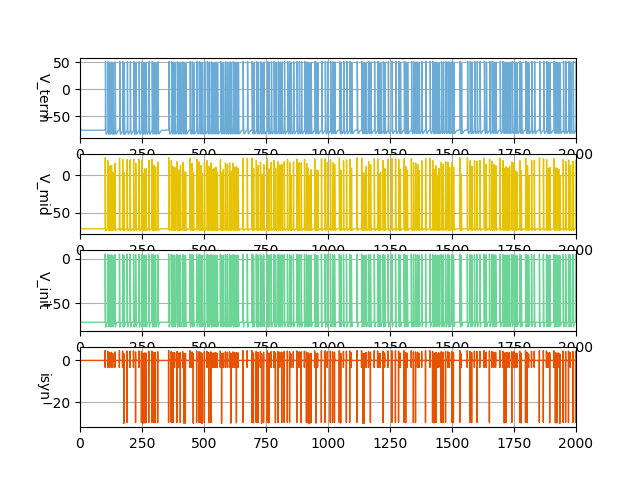

In [8]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

In [9]:
spikes_start = np.array(spike_vecs['ax_init'])
spikes_term = np.array(spike_vecs['ax_term'])

propagation_delay = spikes_term[-1] - spikes_start[-1]
axon_length = sum((sec.L for sec in icell.all))

print("Axon length (mm): L = %f" % (1e-3 * axon_length))
print("Last propagation delay (ms): dt = %f" % propagation_delay)
print("Conduction speed (um/ms) = %f" % (axon_length / propagation_delay))
print("Conduction speed (m/s) = %f" % (1e-3 * axon_length / propagation_delay))

Axon length (mm): L = 1.207836
Last propagation delay (ms): dt = 1.475000
Conduction speed (um/ms) = 818.872079
Conduction speed (m/s) = 0.818872


<IPython.core.display.Javascript object>


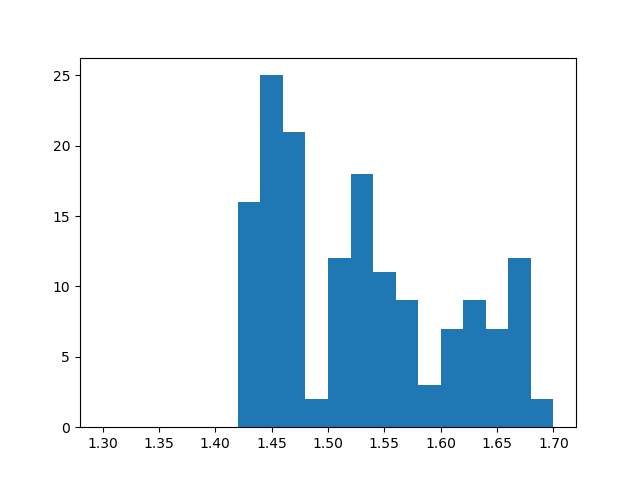

Median delay is 1.550000 (bin 1.440000)


In [10]:
# Draw popagation delay histogram
all_delays = spikes_term - spikes_start

fig, ax = plt.subplots()
bin_counts, bin_low, patches = ax.hist(all_delays, range=(1.3, 1.7), bins=20)
bin_max = bin_low[np.argmax(bin_counts)]
print("Median delay is %f (bin %f)" % (np.median(all_delays), bin_max))